In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fer-2013df.zip to fer-2013df.zip


In [ ]:
!ls /content

fer-2013df.zip	sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Unzip data
!unzip /content/fer-2013df.zip

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: fer-2013/sad/Training_65267116.jpg  
 extracting: fer-2013/sad/Training_65275626.jpg  
 extracting: fer-2013/sad/Training_6529266.jpg  
 extracting: fer-2013/sad/Training_65329617.jpg  
 extracting: fer-2013/sad/Training_65338712.jpg  
 extracting: fer-2013/sad/Training_65338797.jpg  
 extracting: fer-2013/sad/Training_65387162.jpg  
 extracting: fer-2013/sad/Training_65404494.jpg  
 extracting: fer-2013/sad/Training_65426218.jpg  
 extracting: fer-2013/sad/Training_65430136.jpg  
 extracting: fer-2013/sad/Training_65437377.jpg  
 extracting: fer-2013/sad/Training_6545735.jpg  
 extracting: fer-2013/sad/Training_65463385.jpg  
 extracting: fer-2013/sad/Training_65473985.jpg  
 extracting: fer-2013/sad/Training_65502829.jpg  
 extracting: fer-2013/sad/Training_65505359.jpg  
 extracting: fer-2013/sad/Training_65508578.jpg  
 extracting: fer-2013/sad/Training_65516023.jpg  
 extracting: fer-2013/sad/Training_65524027.jpg  
 extracting: fer-2013/sad

In [ ]:
img_height = 224
img_width = 224
batch_size = 32

In [ ]:
#Load data using keras utils
train_ds = tf.keras.utils.image_dataset_from_directory(
    "fer-2013",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "fer-2013",
    validation_split=0.3,
    subset="validation",
    seed=1337,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 8612 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


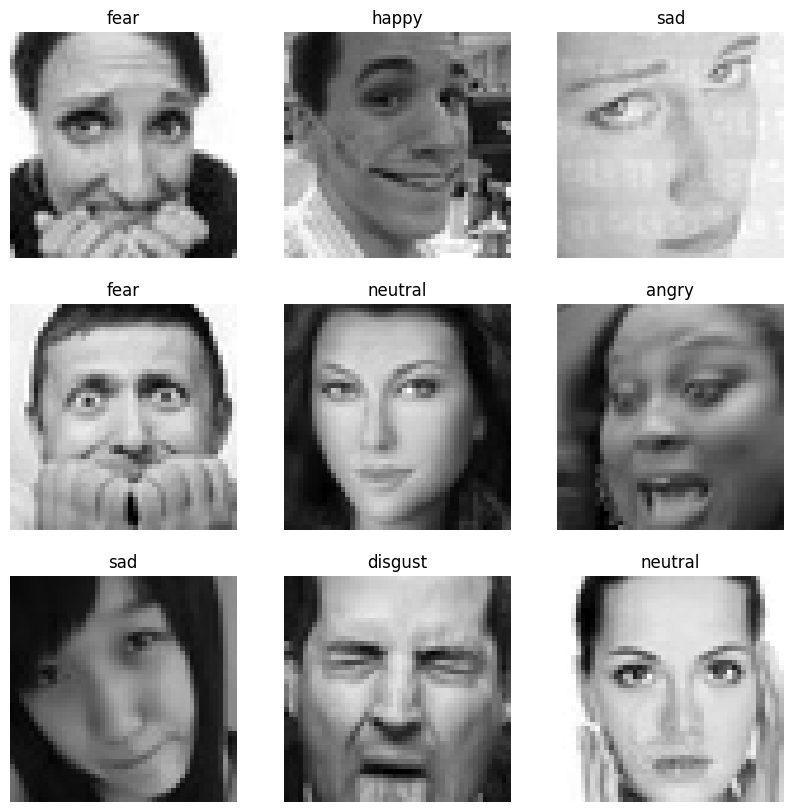

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Transfer Learning

### Model 1 MobileNet

In [ ]:
#Load the MobileNetV2 pre-trained model
#include_top=False means that you’re not interested in the last layer of the model. You will be creating and training this layer yourself.
base_model3 = keras.applications.MobileNetV2(
    weights='imagenet',
    input_shape=(img_height, img_width, 3),
    include_top=False)

In [ ]:
base_model3.trainable = False

In [ ]:
inputs = keras.Input(shape=(img_height, img_width, 3))
x = tf.keras.applications.xception.preprocess_input(inputs)
x = base_model3(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(7)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 48, 48, 3)         0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 48, 48, 3)         0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                 

In [ ]:
history = model.fit(train_ds, epochs=100, validation_data=test_ds)

Epoch 1/100
718/718 [==============================] - 16s 16ms/step - loss: 1.7482 - accuracy: 0.3036 - val_loss: 1.5972 - val_accuracy: 0.3883
Epoch 2/100
718/718 [==============================] - 11s 16ms/step - loss: 1.6222 - accuracy: 0.3682 - val_loss: 1.5504 - val_accuracy: 0.4134
Epoch 3/100
718/718 [==============================] - 11s 16ms/step - loss: 1.5730 - accuracy: 0.3896 - val_loss: 1.5096 - val_accuracy: 0.4289
Epoch 4/100
718/718 [==============================] - 10s 14ms/step - loss: 1.5271 - accuracy: 0.4161 - val_loss: 1.4827 - val_accuracy: 0.4390
Epoch 5/100
718/718 [==============================] - 11s 15ms/step - loss: 1.4921 - accuracy: 0.4307 - val_loss: 1.4595 - val_accuracy: 0.4493
Epoch 6/100
718/718 [==============================] - 11s 16ms/step - loss: 1.4583 - accuracy: 0.4419 - val_loss: 1.4451 - val_accuracy: 0.4570
Epoch 7/100
718/718 [==============================] - 15s 21ms/step - loss: 1.4182 - accuracy: 0.4605 - val_loss: 1.4353 - val_ac

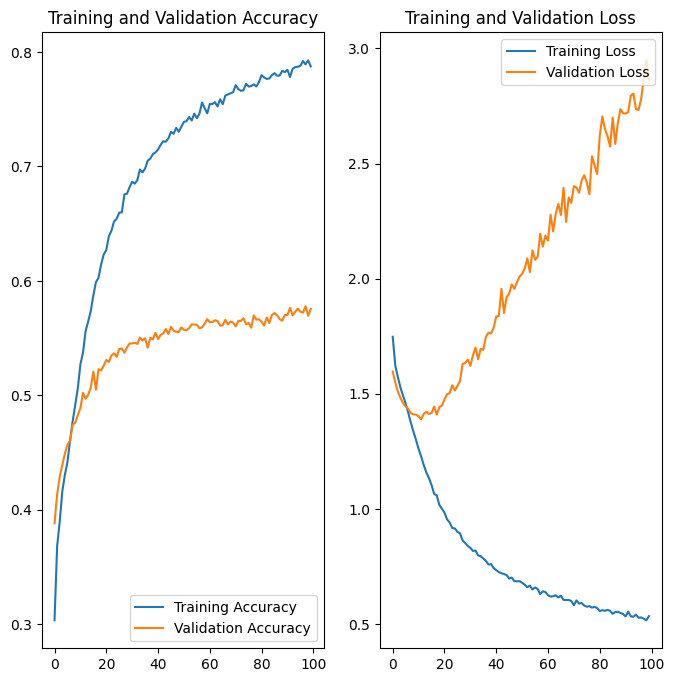

In [ ]:
#Plot training and test accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(100)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()